In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, Math

from qiskit.circuit import Gate
from qiskit.visualization import circuit_drawer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

/var/folders/68/hbr1dyps0n12whylkwtz1k740000gn/T/ipykernel_19457/1652261825.py:6: DeprecationWarning: Using Qiskit with Python 3.9 is deprecated as of the 2.1.0 release. Support for running Qiskit with Python 3.9 will be removed in the 2.3.0 release, which coincides with when Python 3.9 goes end of life.
  from qiskit.circuit import Gate


In [2]:
np.random.seed(0)

In [3]:
# the code is [[4, 2, 2]]
# we encode 2 logical qubits into 4 physical qubits

Hx = np.array([
    [1, 1, 1, 1]
], dtype=int)

Hz = np.array([
    [1, 1, 1, 1]
], dtype=int)

Lx = np.array([[1, 1, 0, 0], [1, 0, 1, 0]])
Lz = np.array([[1, 0, 0, 1], [0, 1, 1, 0]])

print(f"We have {Hx.shape[1]} data qubits")
print(f"We have {Hx.shape[0]} X-Stabilizers")
print(f"We have {Hz.shape[0]} Z-Stabilizers")
print(f"We have {Hx.shape[1] + Hx.shape[0] + Hz.shape[0]} physical qubits")
print(f"We have {Lx.shape[0]} logical qubits")


We have 4 data qubits
We have 1 X-Stabilizers
We have 1 Z-Stabilizers
We have 6 physical qubits
We have 2 logical qubits


In [4]:
orthogonality = (Hx @ Hz.T) % 2
display(Math(r'\text{Orthogonality test: } H_X \cdot H_Z^T \text{ mod 2 gave}'))

<IPython.core.display.Math object>

In [5]:
anticommutation = (Lx @ Lz.T) - (Lz @ Lx.T)
print(anticommutation)

[[0 0]
 [0 0]]


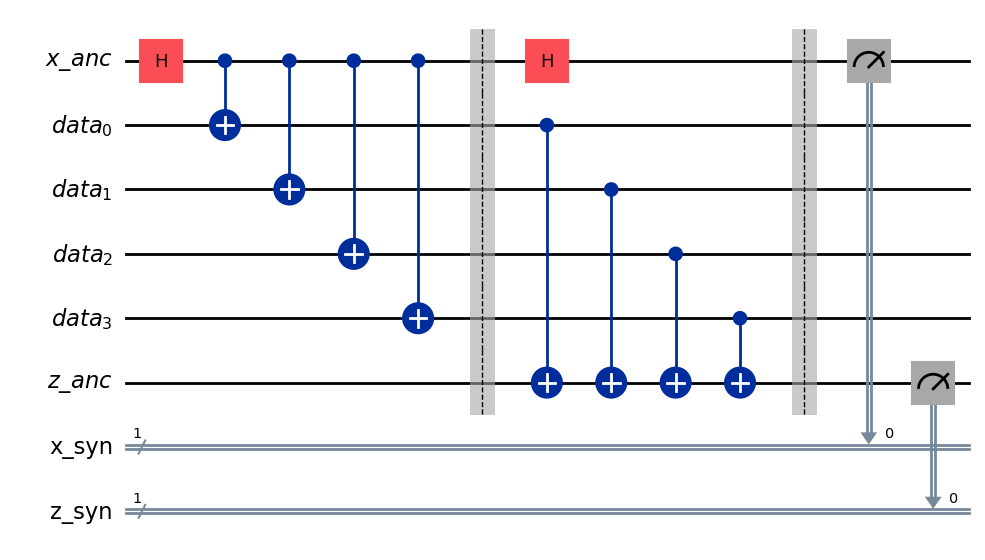

In [6]:
data = QuantumRegister(4, 'data')
x_ancillas = QuantumRegister(1, 'x_anc')
z_ancillas = QuantumRegister(1, 'z_anc')

x_meas = ClassicalRegister(1, 'x_syn')
z_meas = ClassicalRegister(1, 'z_syn')

qc = QuantumCircuit(x_ancillas, data, z_ancillas, x_meas, z_meas)

qc.h(x_ancillas)

qc.cx(x_ancillas, data[0])
qc.cx(x_ancillas, data[1])
qc.cx(x_ancillas, data[2])
qc.cx(x_ancillas, data[3])

qc.barrier()

qc.cx(data[0], z_ancillas)
qc.cx(data[1], z_ancillas)
qc.cx(data[2], z_ancillas)
qc.cx(data[3], z_ancillas)

qc.h(x_ancillas)

qc.barrier()

qc.measure(x_ancillas, x_meas)
qc.measure(z_ancillas,z_meas)

circuit_drawer(qc, output="mpl")

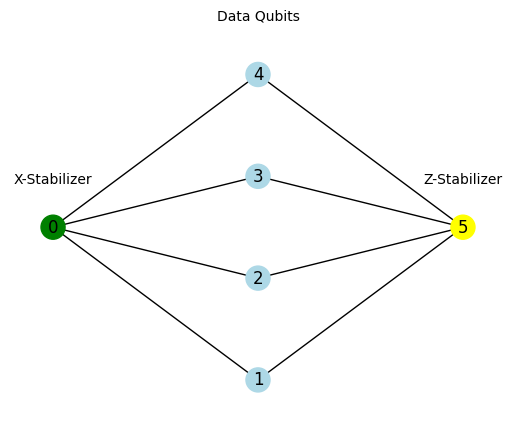

In [7]:
G = nx.Graph()

G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(0, 3)
G.add_edge(0, 4)

G.add_edge(1, 5)
G.add_edge(2, 5)
G.add_edge(3, 5)
G.add_edge(4, 5)

pos = {
    0: (0, 0), 
    1: (1, -1.5), 
    2: (1, -0.5), 
    3: (1, 0.5), 
    4: (1, 1.5), 
    5: (2, 0), 
}

node_colors = ['green' if node in [0] else 'yellow' if node in [5] else 'lightblue' for node in G.nodes()]
nx.draw_networkx(G, pos, node_color=node_colors, edge_color=None)

plt.text(0, 0.4, 'X-Stabilizer', ha='center', va='bottom', fontsize=10)
plt.text(2, 0.4, 'Z-Stabilizer', ha='center', va='bottom', fontsize=10)
plt.text(1, 2, 'Data Qubits', ha='center', va='bottom', fontsize=10)

ax = plt.gca()
plt.axis("off")
plt.show()

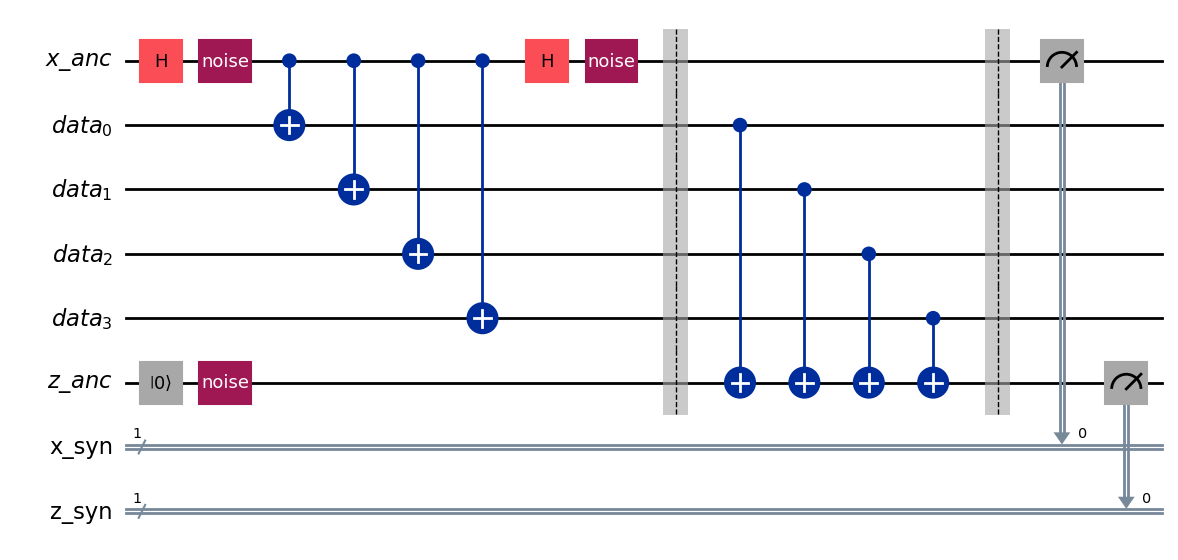

In [25]:
# Circuit visualization with noise locations marked
# (Just for illustration - actual simulation uses tuple representation)

data = QuantumRegister(4, 'data')
x_ancillas = QuantumRegister(1, 'x_anc')
z_ancillas = QuantumRegister(1, 'z_anc')

x_meas = ClassicalRegister(1, 'x_syn')
z_meas = ClassicalRegister(1, 'z_syn')

noise_gate = Gate('noise', 1, [])
idle_gate = Gate('idle', 1, [])

qc = QuantumCircuit(x_ancillas, data, z_ancillas, x_meas, z_meas)

qc.h(x_ancillas)
qc.append(noise_gate, x_ancillas)
qc.reset(z_ancillas)
qc.append(noise_gate, z_ancillas)

for i in range(4):
    qc.cx(x_ancillas, data[i])

qc.h(x_ancillas)
qc.append(noise_gate, x_ancillas)

qc.barrier()

for i in range(4):
    qc.cx(data[i], z_ancillas)

qc.barrier()

qc.measure(x_ancillas, x_meas)
qc.measure(z_ancillas, z_meas)

circuit_drawer(qc, output="mpl")

# Part 2: Circuit-Level Noise Model - From Scratch

This part demonstrates the **circuit-level noise model** step by step, with plain (non-optimized) implementations that are easy to understand. 

## Key Concepts We'll Cover:
1. **Circuit Representation** - How we represent the syndrome extraction circuit
2. **Noise Injection** - Where and how errors are introduced
3. **Error Propagation** - How Pauli errors propagate through gates (X and Z are tracked separately)
4. **Syndrome Extraction** - Recording measurement outcomes
5. **Syndrome Sparsification** - Converting raw syndromes to differential syndromes
6. **Decoding Matrix Construction** - Enumerating faults and building the decoding matrix
7. **Logical Operator Integration** - How logical operators define what "success" means
8. **Decoding** - Using the constructed matrices to correct errors

---

### ⚠️ Critical Difference from Code-Capacity Model

| Aspect | Code-Capacity | Circuit-Level |
|--------|---------------|---------------|
| **Syndrome** | $m$ bits (one per check) | $m \times T$ bits (check × time) |
| **Matrix columns** | Physical qubits | **Fault equivalence classes** |
| **Matrix construction** | From code definition | **From simulation** |
| **Decoding finds** | Which qubits have errors | **Logical effect of faults** |

## Step 1: Circuit Representation

We represent the circuit as a list of tuples. Each operation is:
- `('PrepX', qubit)` - Prepare in |+⟩ state
- `('PrepZ', qubit)` - Prepare in |0⟩ state  
- `('CNOT', control, target)` - CNOT gate
- `('MeasX', qubit)` - Measure in X-basis
- `('MeasZ', qubit)` - Measure in Z-basis
- `('IDLE', qubit)` - Qubit idles (still susceptible to noise)

Qubit labels are tuples like `('Xcheck', 0)`, `('Zcheck', 0)`, `('data', i)`

In [26]:
def build_circuit_single_cycle():
    
    cycle = []
    
    cycle.append(('PrepX', ('Xcheck', 0)))
    cycle.append(('PrepZ', ('Zcheck', 0)))
    
    for i in range(4):
        cycle.append(('CNOT', ('Xcheck', 0), ('data', i)))
    
    for i in range(4):
        cycle.append(('CNOT', ('data', i), ('Zcheck', 0)))
    
    cycle.append(('MeasX', ('Xcheck', 0)))
    cycle.append(('MeasZ', ('Zcheck', 0)))
    
    return cycle

NUM_CYCLES = 2
single_cycle = build_circuit_single_cycle()
full_circuit = single_cycle * NUM_CYCLES

print(f"Single cycle has {len(single_cycle)} operations:")
for i, op in enumerate(single_cycle):
    print(f"  {i}: {op}")
    
print(f"\nFull circuit: {NUM_CYCLES} cycles × {len(single_cycle)} ops = {len(full_circuit)} operations")

Single cycle has 12 operations:
  0: ('PrepX', ('Xcheck', 0))
  1: ('PrepZ', ('Zcheck', 0))
  2: ('CNOT', ('Xcheck', 0), ('data', 0))
  3: ('CNOT', ('Xcheck', 0), ('data', 1))
  4: ('CNOT', ('Xcheck', 0), ('data', 2))
  5: ('CNOT', ('Xcheck', 0), ('data', 3))
  6: ('CNOT', ('data', 0), ('Zcheck', 0))
  7: ('CNOT', ('data', 1), ('Zcheck', 0))
  8: ('CNOT', ('data', 2), ('Zcheck', 0))
  9: ('CNOT', ('data', 3), ('Zcheck', 0))
  10: ('MeasX', ('Xcheck', 0))
  11: ('MeasZ', ('Zcheck', 0))

Full circuit: 2 cycles × 12 ops = 24 operations


In [27]:
def build_qubit_mapping():
    lin_order = {}
    idx = 0
    
    Xchecks = [('Xcheck', 0)]
    for q in Xchecks:
        lin_order[q] = idx
        idx += 1
    
    Zchecks = [('Zcheck', 0)]
    for q in Zchecks:
        lin_order[q] = idx
        idx += 1
    
    data_qubits = [('data', i) for i in range(4)]
    for q in data_qubits:
        lin_order[q] = idx
        idx += 1
    
    return lin_order, Xchecks, Zchecks, data_qubits

lin_order, Xchecks, Zchecks, data_qubits = build_qubit_mapping()

# print("Qubit Index Mapping:")
# print("=" * 40)
# for qubit, idx in lin_order.items():
#     print(f"  {qubit} → index {idx}")
# print(f"\nTotal qubits: {len(lin_order)}")
# print(f"X-checks: {Xchecks}")
# print(f"Z-checks: {Zchecks}")
# print(f"Data qubits: {data_qubits}")

## Step 2: Error Propagation Simulation

The key insight of circuit-level noise simulation is that **Z and X errors propagate independently**.

### Z-Error Propagation Rules:
- **CNOT**: Z on target → Z on both (propagates to control via phase kickback)
- **PrepX**: Resets Z error to 0 (projects to X eigenstate)
- **MeasX**: Z error flips the measurement outcome

### X-Error Propagation Rules:
- **CNOT**: X on control → X on both (propagates to target)
- **PrepZ**: Resets X error to 0 (projects to Z eigenstate)
- **MeasZ**: X error flips the measurement outcome

```
Z through CNOT:              X through CNOT:
      ┌───┐                        ┌───┐
ctrl ─┤   ├─ ctrl⊕Z         ctrl ──┤   ├── ctrl
      │ C │                        │ C │
tgt ─Z┤ N ├─ tgt             tgt ─X┤ N ├─ tgt⊕X
      │ O │                        │ O │
      │ T │                        │ T │
      └───┘                        └───┘
```

In [ ]:
def simulate_circuit_Z(circuit, lin_order, Xchecks):

    total_qubits = len(lin_order)
    state = np.zeros(total_qubits, dtype=int)
    
    syndrome_history = []
    syndrome_map = {c: [] for c in Xchecks}
    syn_idx = 0
    
    for gate in circuit:
        gate_type = gate[0]
        
        if gate_type == 'CNOT':
            ctrl_idx = lin_order[gate[1]]
            tgt_idx = lin_order[gate[2]]
            
            state[ctrl_idx] = (state[ctrl_idx] + state[tgt_idx]) % 2
            
        elif gate_type == 'PrepX':
            q_idx = lin_order[gate[1]]
            state[q_idx] = 0
            
        elif gate_type == 'MeasX':
            q_idx = lin_order[gate[1]]
            check_label = gate[1]
            syndrome_history.append(state[q_idx])
            syndrome_map[check_label].append(syn_idx)
            syn_idx += 1
            
        elif gate_type in ['Z', 'Y']:
            q_idx = lin_order[gate[1]]
            state[q_idx] = (state[q_idx] + 1) % 2
            
        elif gate_type in ['ZZ', 'YY', 'YZ', 'ZY']:
            q1_idx = lin_order[gate[1]]
            q2_idx = lin_order[gate[2]]
            state[q1_idx] = (state[q1_idx] + 1) % 2
            state[q2_idx] = (state[q2_idx] + 1) % 2
            
        elif gate_type in ['ZX', 'YX']:
            q_idx = lin_order[gate[1]]
            state[q_idx] = (state[q_idx] + 1) % 2
            
        elif gate_type in ['XZ', 'XY']:
            q_idx = lin_order[gate[2]]
            state[q_idx] = (state[q_idx] + 1) % 2
    
    return np.array(syndrome_history), state, syndrome_map


def simulate_circuit_X(circuit, lin_order, Zchecks):
    total_qubits = len(lin_order)
    state = np.zeros(total_qubits, dtype=int)
    
    syndrome_history = []
    syndrome_map = {c: [] for c in Zchecks}
    syn_idx = 0
    
    for gate in circuit:
        gate_type = gate[0]
        
        if gate_type == 'CNOT':
            ctrl_idx = lin_order[gate[1]]
            tgt_idx = lin_order[gate[2]]
            state[tgt_idx] = (state[tgt_idx] + state[ctrl_idx]) % 2
            
        elif gate_type == 'PrepZ':
            q_idx = lin_order[gate[1]]
            state[q_idx] = 0
            
        elif gate_type == 'MeasZ':
            q_idx = lin_order[gate[1]]
            check_label = gate[1]
            syndrome_history.append(state[q_idx])
            syndrome_map[check_label].append(syn_idx)
            syn_idx += 1
            
        elif gate_type in ['X', 'Y']:
            q_idx = lin_order[gate[1]]
            state[q_idx] = (state[q_idx] + 1) % 2
            
        elif gate_type in ['XX', 'YY', 'XY', 'YX']:
            q1_idx = lin_order[gate[1]]
            q2_idx = lin_order[gate[2]]
            state[q1_idx] = (state[q1_idx] + 1) % 2
            state[q2_idx] = (state[q2_idx] + 1) % 2
            
        elif gate_type in ['XZ', 'YZ']:
            q_idx = lin_order[gate[1]]
            state[q_idx] = (state[q_idx] + 1) % 2
            
        elif gate_type in ['ZX', 'ZY']:
            q_idx = lin_order[gate[2]]
            state[q_idx] = (state[q_idx] + 1) % 2
    
    return np.array(syndrome_history), state, syndrome_map

Simulation functions defined!


## Step 3: Syndrome Sparsification

Raw syndromes have a problem: a single error can flip **all subsequent measurements** of a check. This makes decoding harder because errors "persist" in the syndrome.

**Sparsification** computes the XOR of consecutive measurements:
$$\text{sparse}[t] = \text{raw}[t] \oplus \text{raw}[t-1]$$

This gives us **1** only at timesteps where the syndrome **changed**.

```
Check C₀ across 4 cycles:
  Cycle:    1    2    3    4
  Raw:      0    0    1    1    ← Error occurred before cycle 3
  Sparse:   0    0    1    0    ← Only cycle 3 shows change!
```

In [12]:
# =============================================================================
# SYNDROME SPARSIFICATION
# =============================================================================

def sparsify_syndrome(syndrome_history, syndrome_map, checks):
    """
    Convert raw syndrome to sparsified (differential) syndrome.
    
    For each check, XOR consecutive measurements so we only see
    changes in the syndrome, not persistent values.
    
    Args:
        syndrome_history: Raw measurement outcomes
        syndrome_map: Dict mapping check → list of syndrome indices
        checks: List of check labels
        
    Returns:
        Sparsified syndrome array
    """
    result = syndrome_history.copy()
    
    for check in checks:
        positions = syndrome_map[check]  # Indices where this check was measured
        # XOR consecutive measurements
        for i in range(1, len(positions)):
            prev_idx = positions[i - 1]
            curr_idx = positions[i]
            result[curr_idx] = (result[curr_idx] + syndrome_history[prev_idx]) % 2
    
    return result

# Demonstration of sparsification
print("=== Sparsification Demonstration ===\n")

# Create a circuit with an error injected at a specific time
demo_circuit = full_circuit.copy()
# Insert a Z error on data qubit 0 after the 3rd CNOT of cycle 3
# This should affect X-check measurements from cycle 3 onwards
error_position = 2 * len(single_cycle) + 3  # In cycle 3, after some CNOTs
demo_circuit_with_error = demo_circuit[:error_position] + [('Z', ('data', 0))] + demo_circuit[error_position:]

# Simulate
raw_syndrome, final_state, syn_map = simulate_circuit_Z(demo_circuit_with_error, lin_order, Xchecks)
sparse_syndrome = sparsify_syndrome(raw_syndrome, syn_map, Xchecks)

print(f"Error injected at position {error_position} (cycle 3)")
print(f"\nRaw X-syndrome (across {NUM_CYCLES} cycles):")
print(f"  {raw_syndrome}")
print(f"\nSparsified X-syndrome:")
print(f"  {sparse_syndrome}")
print(f"\nNon-zero positions in raw:    {np.nonzero(raw_syndrome)[0]}")
print(f"Non-zero positions in sparse: {np.nonzero(sparse_syndrome)[0]}")
print("\n→ Notice how sparsification localizes the error in time!")

=== Sparsification Demonstration ===

Error injected at position 27 (cycle 3)

Raw X-syndrome (across 10 cycles):
  [0 0 0 1 1 1 1 1 1 1]

Sparsified X-syndrome:
  [0 0 0 1 0 0 0 0 0 0]

Non-zero positions in raw:    [3 4 5 6 7 8 9]
Non-zero positions in sparse: [3]

→ Notice how sparsification localizes the error in time!


## Step 4: The Depolarizing Noise Model

In circuit-level noise, errors can occur at multiple locations:

| Location | Error Type | Probability | Syndrome Affected |
|----------|-----------|-------------|-------------------|
| **MeasX** | Z before measurement | $p$ | X-check |
| **MeasZ** | X before measurement | $p$ | Z-check |
| **PrepX** | Z after preparation | $p$ | X-check |
| **PrepZ** | X after preparation | $p$ | Z-check |
| **IDLE** | X, Y, or Z (1/3 each) | $p$ | Both (Y = XZ) |
| **CNOT** | One of 15 two-qubit Paulis | $p$ | Both |

### CNOT Error Details
After a CNOT, one of 15 equally likely two-qubit Paulis can occur:
- 3 on control only: X⊗I, Y⊗I, Z⊗I  
- 3 on target only: I⊗X, I⊗Y, I⊗Z
- 9 correlated: XX, XY, XZ, YX, YY, YZ, ZX, ZY, ZZ

The probability that a fault has a Z-component on a specific qubit is $\frac{4}{15}p$ (4 out of 15 Paulis have Z on each position).

In [13]:
# =============================================================================
# NOISY CIRCUIT GENERATION
# =============================================================================

def generate_noisy_circuit(circuit, error_rate):
    """
    Generate a noisy version of the circuit by probabilistically inserting Pauli errors.
    
    This implements the depolarizing noise model:
    - MeasX: Z error BEFORE measurement with prob p
    - MeasZ: X error BEFORE measurement with prob p
    - PrepX: Z error AFTER preparation with prob p
    - PrepZ: X error AFTER preparation with prob p
    - IDLE: Random X/Y/Z with prob p
    - CNOT: One of 15 two-qubit Paulis AFTER gate with prob p
    """
    noisy = []
    
    # The 15 possible two-qubit Pauli errors after CNOT
    TWO_QUBIT_PAULIS = [
        ('X', 'ctrl'), ('Y', 'ctrl'), ('Z', 'ctrl'),        # On control only
        ('X', 'tgt'), ('Y', 'tgt'), ('Z', 'tgt'),           # On target only  
        ('XX',), ('YY',), ('ZZ',),                          # Correlated same
        ('XY',), ('YX',), ('YZ',), ('ZY',), ('XZ',), ('ZX',) # Correlated different
    ]
    
    for gate in circuit:
        gate_type = gate[0]
        
        if gate_type == 'MeasX':
            # Z error BEFORE measurement (flips outcome)
            if np.random.random() < error_rate:
                noisy.append(('Z', gate[1]))
            noisy.append(gate)
            
        elif gate_type == 'MeasZ':
            # X error BEFORE measurement
            if np.random.random() < error_rate:
                noisy.append(('X', gate[1]))
            noisy.append(gate)
            
        elif gate_type == 'PrepX':
            # Z error AFTER preparation
            noisy.append(gate)
            if np.random.random() < error_rate:
                noisy.append(('Z', gate[1]))
                
        elif gate_type == 'PrepZ':
            # X error AFTER preparation
            noisy.append(gate)
            if np.random.random() < error_rate:
                noisy.append(('X', gate[1]))
                
        elif gate_type == 'IDLE':
            # Random Pauli X, Y, or Z
            if np.random.random() < error_rate:
                pauli = np.random.choice(['X', 'Y', 'Z'])
                noisy.append((pauli, gate[1]))
            # Note: IDLE itself doesn't need to be in the circuit
            
        elif gate_type == 'CNOT':
            noisy.append(gate)
            # Two-qubit depolarizing after CNOT
            if np.random.random() < error_rate:
                err_idx = np.random.randint(15)
                control, target = gate[1], gate[2]
                
                if err_idx < 3:  # On control only
                    pauli = ['X', 'Y', 'Z'][err_idx]
                    noisy.append((pauli, control))
                elif err_idx < 6:  # On target only
                    pauli = ['X', 'Y', 'Z'][err_idx - 3]
                    noisy.append((pauli, target))
                else:  # Correlated
                    correlated = ['XX', 'YY', 'ZZ', 'XY', 'YX', 'YZ', 'ZY', 'XZ', 'ZX']
                    pauli = correlated[err_idx - 6]
                    noisy.append((pauli, control, target))
        else:
            noisy.append(gate)
            
    return noisy

print("Noise generation function defined!")

Noise generation function defined!


## Step 5: Building the Decoding Matrix

This is the **most important part**. The decoding matrix $H_{\text{dec}}$ is built by:

1. **Enumerate all possible single faults** in the circuit
2. **Simulate each fault** to get its syndrome pattern + logical effect
3. **Group faults with identical (syndrome, logical)** into equivalence classes
4. **Each equivalence class becomes one column** of $H_{\text{dec}}$
5. **Sum probabilities** of faults in each class to get channel probabilities

### Why This Works

We can't distinguish faults that produce the same syndrome and logical effect. So we treat them as one "super-fault" with summed probability.

### Structure of the Full Matrix

```
                  Fault Equivalence Classes
                  ┌───────────────────────┐
                  │ F₀  F₁  F₂  ...  F_N  │
              ┌───┼───────────────────────┤
  (Check,t=1) │   │  1   0   1   ...   0  │  ← Syndrome part
  (Check,t=2) │ H │  0   1   0   ...   1  │
      ...     │dec│  .   .   .   ...   .  │
  (Check,t=T) │   │  0   1   1   ...   0  │
              ├───┼───────────────────────┤
      L₀      │   │  1   0   0   ...   1  │  ← Logical effect part
      L₁      │   │  0   1   0   ...   0  │
              └───┴───────────────────────┘
```

The last $k$ rows encode the **logical effect** of each fault class.

In [14]:
# =============================================================================
# FAULT ENUMERATION - What faults can occur?
# =============================================================================

def enumerate_faults_Z(circuit, error_rate):
    """
    Enumerate all possible Z-type faults (affecting X-checks).
    
    Returns:
        fault_specs: List of (position, error_tuple) for each possible fault
        fault_probs: Probability of each fault
    """
    fault_specs = []
    fault_probs = []
    
    for pos, gate in enumerate(circuit):
        gate_type = gate[0]
        
        if gate_type == 'MeasX':
            # Z error BEFORE MeasX
            fault_specs.append((pos, ('Z', gate[1])))
            fault_probs.append(error_rate)
            
        elif gate_type == 'PrepX':
            # Z error AFTER PrepX
            fault_specs.append((pos + 1, ('Z', gate[1])))
            fault_probs.append(error_rate)
            
        elif gate_type == 'IDLE':
            # Z or Y error (both have Z component)
            # P(Z) = p/3, P(Y) = p/3 → total Z-component prob = 2p/3
            fault_specs.append((pos + 1, ('Z', gate[1])))
            fault_probs.append(error_rate * 2/3)
            
        elif gate_type == 'CNOT':
            control, target = gate[1], gate[2]
            # Z can occur on control, target, or both
            # Out of 15 Paulis: 4 have Z on control, 4 on target, 4 on both
            # But we track them separately for simulation
            for err in [('Z', control), ('Z', target), ('ZZ', control, target)]:
                fault_specs.append((pos + 1, err))
                fault_probs.append(error_rate * 4/15)
                
    return fault_specs, fault_probs

def enumerate_faults_X(circuit, error_rate):
    """
    Enumerate all possible X-type faults (affecting Z-checks).
    """
    fault_specs = []
    fault_probs = []
    
    for pos, gate in enumerate(circuit):
        gate_type = gate[0]
        
        if gate_type == 'MeasZ':
            fault_specs.append((pos, ('X', gate[1])))
            fault_probs.append(error_rate)
            
        elif gate_type == 'PrepZ':
            fault_specs.append((pos + 1, ('X', gate[1])))
            fault_probs.append(error_rate)
            
        elif gate_type == 'IDLE':
            fault_specs.append((pos + 1, ('X', gate[1])))
            fault_probs.append(error_rate * 2/3)
            
        elif gate_type == 'CNOT':
            control, target = gate[1], gate[2]
            for err in [('X', control), ('X', target), ('XX', control, target)]:
                fault_specs.append((pos + 1, err))
                fault_probs.append(error_rate * 4/15)
                
    return fault_specs, fault_probs

# Enumerate faults for our circuit
ERROR_RATE = 0.01
fault_specs_Z, fault_probs_Z = enumerate_faults_Z(full_circuit, ERROR_RATE)
fault_specs_X, fault_probs_X = enumerate_faults_X(full_circuit, ERROR_RATE)

print(f"=== Fault Enumeration ===")
print(f"Z-type faults (affect X-checks): {len(fault_specs_Z)}")
print(f"X-type faults (affect Z-checks): {len(fault_specs_X)}")
print(f"\nFirst 10 Z-type faults:")
for i in range(min(10, len(fault_specs_Z))):
    pos, err = fault_specs_Z[i]
    prob = fault_probs_Z[i]
    print(f"  {i}: Position {pos}, Error {err}, Prob {prob:.6f}")

=== Fault Enumeration ===
Z-type faults (affect X-checks): 260
X-type faults (affect Z-checks): 260

First 10 Z-type faults:
  0: Position 1, Error ('Z', ('Xcheck', 0)), Prob 0.010000
  1: Position 3, Error ('Z', ('Xcheck', 0)), Prob 0.002667
  2: Position 3, Error ('Z', ('data', 0)), Prob 0.002667
  3: Position 3, Error ('ZZ', ('Xcheck', 0), ('data', 0)), Prob 0.002667
  4: Position 4, Error ('Z', ('Xcheck', 0)), Prob 0.002667
  5: Position 4, Error ('Z', ('data', 1)), Prob 0.002667
  6: Position 4, Error ('ZZ', ('Xcheck', 0), ('data', 1)), Prob 0.002667
  7: Position 5, Error ('Z', ('Xcheck', 0)), Prob 0.002667
  8: Position 5, Error ('Z', ('data', 2)), Prob 0.002667
  9: Position 5, Error ('ZZ', ('Xcheck', 0), ('data', 2)), Prob 0.002667


In [15]:
# =============================================================================
# BUILD DECODING MATRIX - The Heart of Circuit-Level Decoding
# =============================================================================

def extract_data_state(state, lin_order, data_qubits):
    """Extract error state on data qubits only."""
    return np.array([state[lin_order[q]] for q in data_qubits])

def build_decoding_matrix_Z(circuit, fault_specs, fault_probs, lin_order, Xchecks, data_qubits, Lx):
    """
    Build the Z-error decoding matrix.
    
    Key steps:
    1. For each fault, inject it into the circuit
    2. Simulate to get sparsified syndrome + logical effect
    3. Group faults with identical (syndrome, logical)
    4. Each group → one column of Hdec
    5. Sum probabilities within groups
    
    Args:
        circuit: Base circuit (without errors)
        fault_specs: List of (position, error_tuple) for each fault
        fault_probs: Probability of each fault
        lin_order: Qubit mapping
        Xchecks: X-check labels
        data_qubits: Data qubit labels
        Lx: Logical X operator matrix
        
    Returns:
        HdecZ: Decoding matrix (syndrome part only)
        HZ_full: Full matrix (syndrome + logical rows)
        channel_probs: Channel probabilities for each column
        num_syndrome_bits: Number of syndrome bits
    """
    # We need a "noiseless suffix" - extra cycles to flush out errors
    # and get final syndrome + data state
    SUFFIX_CYCLES = 2
    noiseless_suffix = single_cycle * SUFFIX_CYCLES
    
    # Total syndrome measurements expected
    num_syndrome_bits = len(Xchecks) * (NUM_CYCLES + SUFFIX_CYCLES)
    k = Lx.shape[0]  # Number of logical qubits
    
    # Dictionary to group faults by their (syndrome, logical) signature
    # Key: tuple of nonzero positions in augmented vector
    # Value: list of fault indices
    equivalence_classes = {}
    
    print(f"Simulating {len(fault_specs)} faults...")
    
    for fault_idx, (pos, error_tuple) in enumerate(fault_specs):
        # Inject this single fault into the circuit
        circuit_with_fault = circuit[:pos] + [error_tuple] + circuit[pos:]
        full_circuit_with_fault = circuit_with_fault + noiseless_suffix
        
        # Simulate Z-error propagation
        raw_syndrome, final_state, syn_map = simulate_circuit_Z(
            full_circuit_with_fault, lin_order, Xchecks
        )
        
        # Sparsify syndrome
        sparse_syndrome = sparsify_syndrome(raw_syndrome, syn_map, Xchecks)
        
        # Get logical effect: does this fault flip logical operators?
        data_state = extract_data_state(final_state, lin_order, data_qubits)
        logical_effect = (Lx @ data_state) % 2  # Z errors detected by Lx anticommutation
        
        # Create augmented vector: [syndrome | logical]
        augmented = np.concatenate([sparse_syndrome, logical_effect])
        
        # Use nonzero positions as key (more efficient than full vector)
        signature = tuple(np.nonzero(augmented)[0])
        
        # Group by signature
        if signature not in equivalence_classes:
            equivalence_classes[signature] = []
        equivalence_classes[signature].append(fault_idx)
    
    print(f"Found {len(equivalence_classes)} equivalence classes (from {len(fault_specs)} faults)")
    
    # Build matrices from equivalence classes
    num_classes = len(equivalence_classes)
    HdecZ = np.zeros((num_syndrome_bits, num_classes), dtype=int)
    HZ_full = np.zeros((num_syndrome_bits + k, num_classes), dtype=int)
    channel_probs = np.zeros(num_classes)
    
    for col_idx, (signature, fault_indices) in enumerate(equivalence_classes.items()):
        # Set nonzero positions in this column
        for pos in signature:
            HZ_full[pos, col_idx] = 1
            if pos < num_syndrome_bits:
                HdecZ[pos, col_idx] = 1
        
        # Sum probabilities of all faults in this class
        channel_probs[col_idx] = sum(fault_probs[i] for i in fault_indices)
    
    return HdecZ, HZ_full, channel_probs, num_syndrome_bits

def build_decoding_matrix_X(circuit, fault_specs, fault_probs, lin_order, Zchecks, data_qubits, Lz):
    """Build the X-error decoding matrix (symmetric to Z)."""
    SUFFIX_CYCLES = 2
    noiseless_suffix = single_cycle * SUFFIX_CYCLES
    
    num_syndrome_bits = len(Zchecks) * (NUM_CYCLES + SUFFIX_CYCLES)
    k = Lz.shape[0]
    
    equivalence_classes = {}
    
    print(f"Simulating {len(fault_specs)} faults...")
    
    for fault_idx, (pos, error_tuple) in enumerate(fault_specs):
        circuit_with_fault = circuit[:pos] + [error_tuple] + circuit[pos:]
        full_circuit_with_fault = circuit_with_fault + noiseless_suffix
        
        raw_syndrome, final_state, syn_map = simulate_circuit_X(
            full_circuit_with_fault, lin_order, Zchecks
        )
        
        sparse_syndrome = sparsify_syndrome(raw_syndrome, syn_map, Zchecks)
        data_state = extract_data_state(final_state, lin_order, data_qubits)
        logical_effect = (Lz @ data_state) % 2  # X errors detected by Lz anticommutation
        
        augmented = np.concatenate([sparse_syndrome, logical_effect])
        signature = tuple(np.nonzero(augmented)[0])
        
        if signature not in equivalence_classes:
            equivalence_classes[signature] = []
        equivalence_classes[signature].append(fault_idx)
    
    print(f"Found {len(equivalence_classes)} equivalence classes (from {len(fault_specs)} faults)")
    
    num_classes = len(equivalence_classes)
    HdecX = np.zeros((num_syndrome_bits, num_classes), dtype=int)
    HX_full = np.zeros((num_syndrome_bits + k, num_classes), dtype=int)
    channel_probs = np.zeros(num_classes)
    
    for col_idx, (signature, fault_indices) in enumerate(equivalence_classes.items()):
        for pos in signature:
            HX_full[pos, col_idx] = 1
            if pos < num_syndrome_bits:
                HdecX[pos, col_idx] = 1
        channel_probs[col_idx] = sum(fault_probs[i] for i in fault_indices)
    
    return HdecX, HX_full, channel_probs, num_syndrome_bits

print("Decoding matrix building functions defined!")

Decoding matrix building functions defined!


In [16]:
# =============================================================================
# BUILD THE DECODING MATRICES
# =============================================================================

print("=" * 60)
print("BUILDING Z-ERROR DECODING MATRIX")
print("=" * 60)
HdecZ, HZ_full, channel_probsZ, num_syndrome_bits_Z = build_decoding_matrix_Z(
    full_circuit, fault_specs_Z, fault_probs_Z, 
    lin_order, Xchecks, data_qubits, Lx
)

print("\n" + "=" * 60)
print("BUILDING X-ERROR DECODING MATRIX")
print("=" * 60)
HdecX, HX_full, channel_probsX, num_syndrome_bits_X = build_decoding_matrix_X(
    full_circuit, fault_specs_X, fault_probs_X,
    lin_order, Zchecks, data_qubits, Lz
)

print("\n" + "=" * 60)
print("MATRIX DIMENSIONS")
print("=" * 60)
print(f"\nZ-Error Decoding:")
print(f"  HdecZ shape: {HdecZ.shape}")
print(f"    - Rows: {HdecZ.shape[0]} (syndrome bits = {len(Xchecks)} checks × {NUM_CYCLES + 2} cycles)")
print(f"    - Cols: {HdecZ.shape[1]} (fault equivalence classes)")
print(f"  HZ_full shape: {HZ_full.shape}")
print(f"    - Extra {Lx.shape[0]} rows for logical operators")
print(f"  Channel probs: {len(channel_probsZ)} values")
print(f"    - Min: {channel_probsZ.min():.6f}")
print(f"    - Max: {channel_probsZ.max():.6f}")
print(f"    - Note: Values > {ERROR_RATE} mean multiple faults merged!")

print(f"\nX-Error Decoding:")
print(f"  HdecX shape: {HdecX.shape}")
print(f"  HX_full shape: {HX_full.shape}")

BUILDING Z-ERROR DECODING MATRIX
Simulating 260 faults...
Found 56 equivalence classes (from 260 faults)

BUILDING X-ERROR DECODING MATRIX
Simulating 260 faults...
Found 34 equivalence classes (from 260 faults)

MATRIX DIMENSIONS

Z-Error Decoding:
  HdecZ shape: (12, 56)
    - Rows: 12 (syndrome bits = 1 checks × 12 cycles)
    - Cols: 56 (fault equivalence classes)
  HZ_full shape: (14, 56)
    - Extra 2 rows for logical operators
  Channel probs: 56 values
    - Min: 0.002667
    - Max: 0.053333
    - Note: Values > 0.01 mean multiple faults merged!

X-Error Decoding:
  HdecX shape: (12, 34)
  HX_full shape: (14, 34)


## Step 6: Understanding Channel Probabilities and LLRs

The **channel probabilities** computed during matrix construction are **crucial** for decoding.

### Why Channel Probabilities ≠ Error Rate

When we merge faults into equivalence classes, we **sum their probabilities**:
$$p_{\text{class}} = \sum_{f \in \text{class}} p_f$$

This means some columns may have higher probability than the physical error rate!

### Log-Likelihood Ratios (LLRs)

The decoder uses LLRs to weight its decisions:
$$\text{LLR}_i = \log\left(\frac{1 - p_i}{p_i}\right)$$

- **High LLR** → Low probability → "probably didn't happen"
- **Low LLR** → High probability → "more likely to have happened"

⚠️ **Critical**: The LLRs must come from the channel probabilities computed during matrix construction, NOT from the raw error rate!

In [17]:
# =============================================================================
# COMPUTE LOG-LIKELIHOOD RATIOS (LLRs)
# =============================================================================

def compute_llr(channel_probs):
    """
    Compute log-likelihood ratios from channel probabilities.
    
    LLR = log((1-p)/p)
    
    Higher LLR → lower probability → less likely to have occurred
    """
    # Clip to avoid division by zero or log of zero
    probs_clipped = np.clip(channel_probs, 1e-10, 1 - 1e-10)
    return np.log((1 - probs_clipped) / probs_clipped)

llr_Z = compute_llr(channel_probsZ)
llr_X = compute_llr(channel_probsX)

print("=== LLR Statistics ===")
print(f"\nZ-error LLRs (for {len(llr_Z)} fault classes):")
print(f"  Min LLR: {llr_Z.min():.2f} (highest probability class)")
print(f"  Max LLR: {llr_Z.max():.2f} (lowest probability class)")
print(f"  Mean LLR: {llr_Z.mean():.2f}")

# Show a few examples
print(f"\nExample channel probabilities vs LLRs:")
print(f"  {'Prob':>10} {'LLR':>10}")
for i in range(min(5, len(channel_probsZ))):
    print(f"  {channel_probsZ[i]:10.6f} {llr_Z[i]:10.2f}")

# Compare with naive error rate
naive_llr = np.log((1 - ERROR_RATE) / ERROR_RATE)
print(f"\n⚠️ If we naively used error rate {ERROR_RATE} for all columns:")
print(f"   Naive LLR would be: {naive_llr:.2f}")
print(f"   But actual LLRs range from {llr_Z.min():.2f} to {llr_Z.max():.2f}!")

=== LLR Statistics ===

Z-error LLRs (for 56 fault classes):
  Min LLR: 2.88 (highest probability class)
  Max LLR: 5.92 (lowest probability class)
  Mean LLR: 4.42

Example channel probabilities vs LLRs:
        Prob        LLR
    0.030667       3.45
    0.013333       4.30
    0.002667       5.92
    0.008000       4.82
    0.002667       5.92

⚠️ If we naively used error rate 0.01 for all columns:
   Naive LLR would be: 4.60
   But actual LLRs range from 2.88 to 5.92!


## Step 7: Simple OSD Decoder

Ordered Statistics Decoding (OSD) is a simple but effective decoder. Here's a plain implementation:

1. **Order columns by reliability** (sort by |LLR|, most reliable first)
2. **Gaussian elimination** on the reordered matrix
3. **Solve for correction** using the pivots
4. **Try flipping** low-reliability bits to find better solutions

In [18]:
# =============================================================================
# SIMPLE OSD DECODER (Plain Implementation)
# =============================================================================

def gf2_gaussian_elimination(H, s):
    """
    Gaussian elimination over GF(2).
    
    Args:
        H: Parity check matrix (will be modified!)
        s: Syndrome vector (will be modified!)
        
    Returns:
        H_reduced: Row-reduced matrix
        s_reduced: Transformed syndrome
        pivot_rows: List of pivot row indices
        pivot_cols: List of pivot column indices
    """
    H = H.copy()
    s = s.copy()
    m, n = H.shape
    pivot_rows = []
    pivot_cols = []
    
    current_row = 0
    for col in range(n):
        # Find a pivot in this column (starting from current_row)
        pivot_found = False
        for row in range(current_row, m):
            if H[row, col] == 1:
                # Swap rows
                H[[current_row, row]] = H[[row, current_row]]
                s[current_row], s[row] = s[row], s[current_row]
                pivot_found = True
                break
        
        if not pivot_found:
            continue
            
        # Record pivot position
        pivot_rows.append(current_row)
        pivot_cols.append(col)
        
        # Eliminate all other 1s in this column
        for row in range(m):
            if row != current_row and H[row, col] == 1:
                H[row] = (H[row] + H[current_row]) % 2
                s[row] = (s[row] + s[current_row]) % 2
        
        current_row += 1
        if current_row >= m:
            break
    
    return H, s, pivot_rows, pivot_cols

def simple_osd_decoder(H, syndrome, llr, order=0):
    """
    Simple OSD decoder implementation.
    
    Args:
        H: Decoding matrix (syndrome part only)
        syndrome: Observed syndrome
        llr: Log-likelihood ratios for each column
        order: OSD order (0 = no extra search, >0 = try flipping bits)
        
    Returns:
        correction: Binary vector indicating which fault classes are in correction
    """
    m, n = H.shape
    
    # Step 1: Order columns by reliability (|LLR|)
    llr_abs = np.abs(llr)
    col_order = np.argsort(llr_abs)  # Most reliable (high |LLR|) will be at end
    
    # Reorder matrix columns
    H_ordered = H[:, col_order]
    llr_ordered = llr[col_order]
    
    # Step 2: Gaussian elimination
    H_reduced, s_reduced, pivot_rows, pivot_cols = gf2_gaussian_elimination(H_ordered.copy(), syndrome.copy())
    
    # Step 3: OSD-0 solution - set pivot columns from syndrome, others to 0
    e_ordered = np.zeros(n, dtype=int)
    for pr, pc in zip(pivot_rows, pivot_cols):
        e_ordered[pc] = s_reduced[pr]
    
    # Convert back to original ordering
    correction = np.zeros(n, dtype=int)
    correction[col_order] = e_ordered
    
    # Check if it's a valid solution
    if np.all((H @ correction) % 2 == syndrome):
        return correction
    
    # If OSD-0 failed and order > 0, try flipping low-reliability bits
    # (This is a simplified version - full OSD is more sophisticated)
    if order > 0:
        pivot_set = set(pivot_cols)
        non_pivot = [i for i in range(n) if i not in pivot_set]
        
        # Try flipping each non-pivot bit
        best_correction = correction
        best_valid = np.all((H @ correction) % 2 == syndrome)
        
        for flip_col in non_pivot[:min(order, len(non_pivot))]:
            e_test = e_ordered.copy()
            e_test[flip_col] ^= 1
            
            # Recompute dependent pivot bits
            for pr, pc in zip(pivot_rows, pivot_cols):
                e_test[pc] = s_reduced[pr]
                for c in range(pc + 1, n):
                    if H_reduced[pr, c] == 1:
                        e_test[pc] ^= e_test[c]
            
            correction_test = np.zeros(n, dtype=int)
            correction_test[col_order] = e_test
            
            is_valid = np.all((H @ correction_test) % 2 == syndrome)
            if is_valid and not best_valid:
                best_correction = correction_test
                best_valid = True
        
        return best_correction
    
    return correction

print("OSD decoder defined!")

OSD decoder defined!


## Step 8: Full Simulation and Decoding Pipeline

Now we put everything together:

1. **Generate noisy circuit** (inject random errors)
2. **Simulate** Z and X error propagation separately
3. **Extract and sparsify** syndromes
4. **Decode** using OSD with proper LLRs
5. **Extract logical correction** from HZ_full/HX_full
6. **Compare** to true logical error

In [19]:
# =============================================================================
# FULL SIMULATION AND DECODING TRIAL
# =============================================================================

def run_single_trial(error_rate, verbose=True):
    """
    Run a complete simulation and decoding trial.
    
    Returns:
        success_Z: True if Z-error correction succeeded
        success_X: True if X-error correction succeeded
    """
    # Noiseless suffix for final syndrome extraction
    SUFFIX_CYCLES = 2
    noiseless_suffix = single_cycle * SUFFIX_CYCLES
    
    # Step 1: Generate noisy circuit
    noisy_circuit = generate_noisy_circuit(full_circuit, error_rate)
    full_noisy_circuit = noisy_circuit + noiseless_suffix  # Noiseless suffix
    
    if verbose:
        # Count errors in the noisy circuit
        error_ops = [g for g in noisy_circuit if g[0] in ['X', 'Y', 'Z', 'XX', 'YY', 'ZZ', 'XY', 'YX', 'XZ', 'ZX', 'YZ', 'ZY']]
        print(f"Generated noisy circuit with {len(error_ops)} error(s)")
        for e in error_ops:
            print(f"  {e}")
    
    # Step 2: Simulate Z-error propagation (affects X-checks)
    raw_syndrome_Z, final_state_Z, syn_map_Z = simulate_circuit_Z(
        full_noisy_circuit, lin_order, Xchecks
    )
    sparse_syndrome_Z = sparsify_syndrome(raw_syndrome_Z, syn_map_Z, Xchecks)
    
    # True Z-type logical error (Z errors anticommute with Lx)
    data_state_Z = extract_data_state(final_state_Z, lin_order, data_qubits)
    true_logical_Z = (Lx @ data_state_Z) % 2
    
    if verbose:
        print(f"\nZ-simulation:")
        print(f"  Sparsified syndrome: {sparse_syndrome_Z}")
        print(f"  Non-zero syndrome bits: {np.nonzero(sparse_syndrome_Z)[0]}")
        print(f"  True logical Z error: {true_logical_Z}")
    
    # Step 3: Decode Z errors
    correction_Z = simple_osd_decoder(HdecZ, sparse_syndrome_Z, llr_Z, order=5)
    
    # Extract predicted logical from HZ_full
    predicted_logical_Z = (HZ_full @ correction_Z)[num_syndrome_bits_Z:] % 2
    
    success_Z = np.array_equal(predicted_logical_Z, true_logical_Z)
    
    if verbose:
        print(f"  Decoder found {np.sum(correction_Z)} fault class(es)")
        print(f"  Predicted logical correction: {predicted_logical_Z}")
        print(f"  SUCCESS: {success_Z}")
    
    # Step 4: Simulate X-error propagation (affects Z-checks)
    raw_syndrome_X, final_state_X, syn_map_X = simulate_circuit_X(
        full_noisy_circuit, lin_order, Zchecks
    )
    sparse_syndrome_X = sparsify_syndrome(raw_syndrome_X, syn_map_X, Zchecks)
    
    # True X-type logical error (X errors anticommute with Lz)
    data_state_X = extract_data_state(final_state_X, lin_order, data_qubits)
    true_logical_X = (Lz @ data_state_X) % 2
    
    if verbose:
        print(f"\nX-simulation:")
        print(f"  Sparsified syndrome: {sparse_syndrome_X}")
        print(f"  Non-zero syndrome bits: {np.nonzero(sparse_syndrome_X)[0]}")
        print(f"  True logical X error: {true_logical_X}")
    
    # Step 5: Decode X errors
    correction_X = simple_osd_decoder(HdecX, sparse_syndrome_X, llr_X, order=5)
    
    # Extract predicted logical from HX_full
    predicted_logical_X = (HX_full @ correction_X)[num_syndrome_bits_X:] % 2
    
    success_X = np.array_equal(predicted_logical_X, true_logical_X)
    
    if verbose:
        print(f"  Decoder found {np.sum(correction_X)} fault class(es)")
        print(f"  Predicted logical correction: {predicted_logical_X}")
        print(f"  SUCCESS: {success_X}")
    
    return success_Z, success_X

print("Trial function defined!")

Trial function defined!


In [20]:
# =============================================================================
# RUN A SINGLE TRIAL WITH DETAILED OUTPUT
# =============================================================================

print("=" * 70)
print("RUNNING SINGLE TRIAL")
print("=" * 70)

np.random.seed(42)  # For reproducibility
success_Z, success_X = run_single_trial(ERROR_RATE, verbose=True)

print("\n" + "=" * 70)
print(f"TRIAL RESULT: Z-correction={'✓' if success_Z else '✗'}, X-correction={'✓' if success_X else '✗'}")
print("=" * 70)

RUNNING SINGLE TRIAL
Generated noisy circuit with 1 error(s)
  ('Z', ('Xcheck', 0))

Z-simulation:
  Sparsified syndrome: [0 0 0 0 0 0 1 1 0 0 0 0]
  Non-zero syndrome bits: [6 7]
  True logical Z error: [0 0]
  Decoder found 1 fault class(es)
  Predicted logical correction: [0 0]
  SUCCESS: True

X-simulation:
  Sparsified syndrome: [0 0 0 0 0 0 0 0 0 0 0 0]
  Non-zero syndrome bits: []
  True logical X error: [0 0]
  Decoder found 0 fault class(es)
  Predicted logical correction: [0 0]
  SUCCESS: True

TRIAL RESULT: Z-correction=✓, X-correction=✓


In [21]:
# =============================================================================
# RUN MULTIPLE TRIALS TO ESTIMATE LOGICAL ERROR RATE
# =============================================================================

def run_multiple_trials(num_trials, error_rate):
    """Run multiple trials and compute success rate."""
    successes_Z = 0
    successes_X = 0
    
    for _ in range(num_trials):
        success_Z, success_X = run_single_trial(error_rate, verbose=False)
        successes_Z += success_Z
        successes_X += success_X
    
    return successes_Z / num_trials, successes_X / num_trials

print("=" * 70)
print("RUNNING MULTIPLE TRIALS")
print("=" * 70)

NUM_TRIALS = 100
print(f"\nRunning {NUM_TRIALS} trials at error rate p = {ERROR_RATE}...")

success_rate_Z, success_rate_X = run_multiple_trials(NUM_TRIALS, ERROR_RATE)

print(f"\nResults over {NUM_TRIALS} trials:")
print(f"  Z-correction success rate: {success_rate_Z:.1%}")
print(f"  X-correction success rate: {success_rate_X:.1%}")
print(f"  Overall (both Z and X correct): ~{success_rate_Z * success_rate_X:.1%}")

RUNNING MULTIPLE TRIALS

Running 100 trials at error rate p = 0.01...

Results over 100 trials:
  Z-correction success rate: 71.0%
  X-correction success rate: 79.0%
  Overall (both Z and X correct): ~56.1%


## Step 9: Visualizing the Decoding Matrix Structure

Let's visualize the structure of our decoding matrices to understand what we've built.

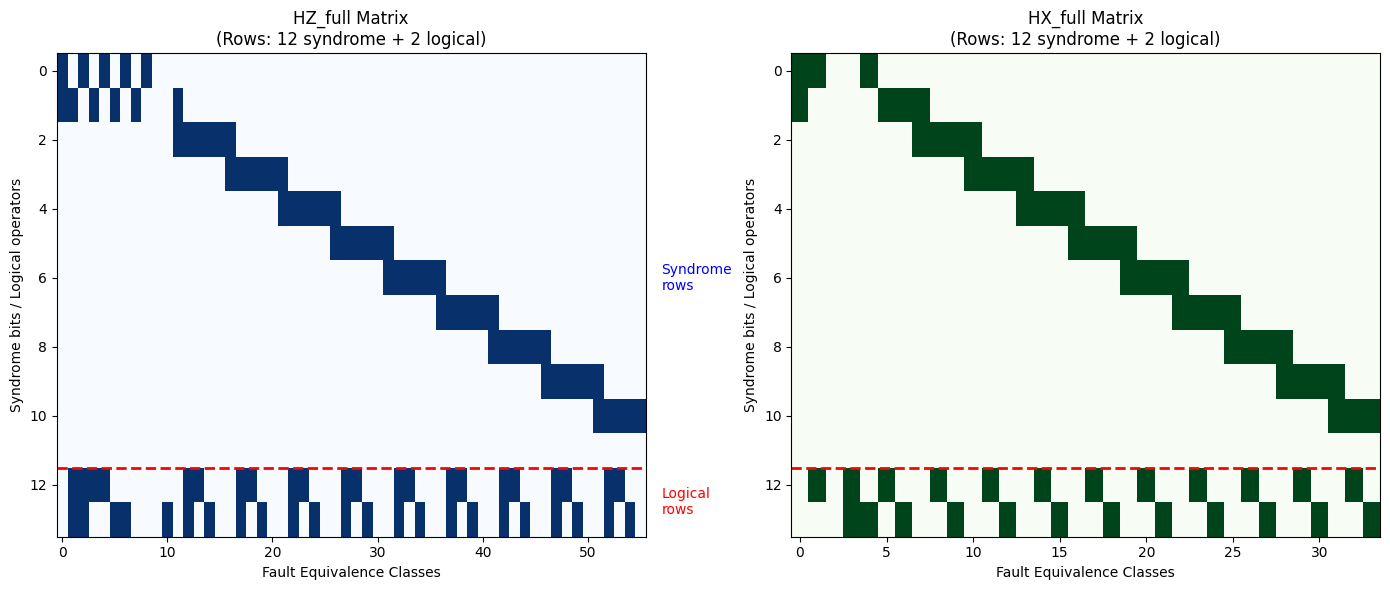


Matrix Interpretation:
  • Each column = one fault equivalence class
  • 1s in syndrome rows = which syndrome bits this fault affects
  • 1s in logical rows = logical effect of this fault
  • Red line separates syndrome (above) from logical (below)


In [22]:
# =============================================================================
# VISUALIZE DECODING MATRIX STRUCTURE
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot HZ_full (syndrome + logical rows)
ax1 = axes[0]
im1 = ax1.imshow(HZ_full, aspect='auto', cmap='Blues', interpolation='nearest')
ax1.axhline(y=num_syndrome_bits_Z - 0.5, color='red', linewidth=2, linestyle='--')
ax1.set_title(f'HZ_full Matrix\n(Rows: {num_syndrome_bits_Z} syndrome + {Lx.shape[0]} logical)', fontsize=12)
ax1.set_xlabel('Fault Equivalence Classes')
ax1.set_ylabel('Syndrome bits / Logical operators')
ax1.text(HZ_full.shape[1] + 1, num_syndrome_bits_Z/2, 'Syndrome\nrows', va='center', fontsize=10, color='blue')
ax1.text(HZ_full.shape[1] + 1, num_syndrome_bits_Z + 0.5, 'Logical\nrows', va='center', fontsize=10, color='red')

# Plot HX_full
ax2 = axes[1]
im2 = ax2.imshow(HX_full, aspect='auto', cmap='Greens', interpolation='nearest')
ax2.axhline(y=num_syndrome_bits_X - 0.5, color='red', linewidth=2, linestyle='--')
ax2.set_title(f'HX_full Matrix\n(Rows: {num_syndrome_bits_X} syndrome + {Lz.shape[0]} logical)', fontsize=12)
ax2.set_xlabel('Fault Equivalence Classes')
ax2.set_ylabel('Syndrome bits / Logical operators')

plt.tight_layout()
plt.show()

print(f"\nMatrix Interpretation:")
print(f"  • Each column = one fault equivalence class")
print(f"  • 1s in syndrome rows = which syndrome bits this fault affects")
print(f"  • 1s in logical rows = logical effect of this fault")
print(f"  • Red line separates syndrome (above) from logical (below)")

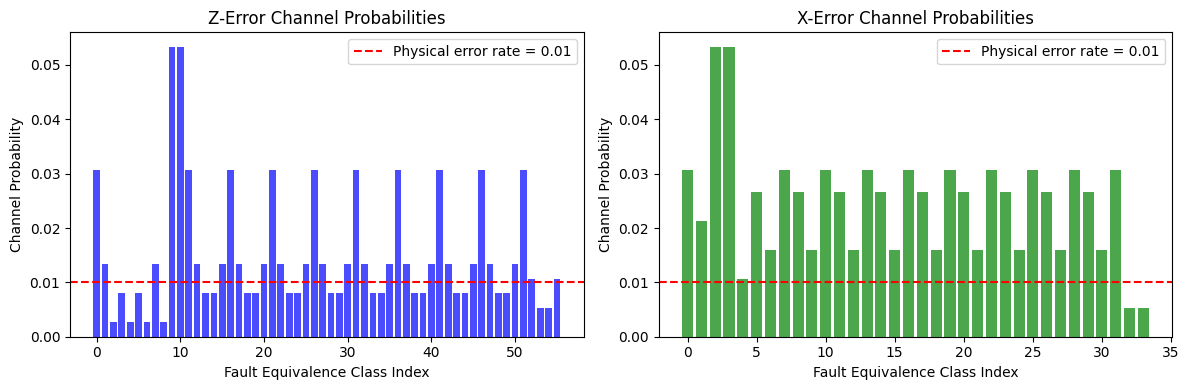


Channel Probability Summary:
  Z-errors: 56 classes, probs in [0.0027, 0.0533]
  X-errors: 34 classes, probs in [0.0053, 0.0533]

  Classes with prob > 0.01:
    Z: 32 (these are merged fault classes)
    X: 32


In [23]:
# =============================================================================
# VISUALIZE CHANNEL PROBABILITIES DISTRIBUTION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Z-error channel probabilities
ax1 = axes[0]
ax1.bar(range(len(channel_probsZ)), channel_probsZ, alpha=0.7, color='blue')
ax1.axhline(y=ERROR_RATE, color='red', linestyle='--', label=f'Physical error rate = {ERROR_RATE}')
ax1.set_xlabel('Fault Equivalence Class Index')
ax1.set_ylabel('Channel Probability')
ax1.set_title('Z-Error Channel Probabilities')
ax1.legend()

# X-error channel probabilities  
ax2 = axes[1]
ax2.bar(range(len(channel_probsX)), channel_probsX, alpha=0.7, color='green')
ax2.axhline(y=ERROR_RATE, color='red', linestyle='--', label=f'Physical error rate = {ERROR_RATE}')
ax2.set_xlabel('Fault Equivalence Class Index')
ax2.set_ylabel('Channel Probability')
ax2.set_title('X-Error Channel Probabilities')
ax2.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\nChannel Probability Summary:")
print(f"  Z-errors: {len(channel_probsZ)} classes, probs in [{channel_probsZ.min():.4f}, {channel_probsZ.max():.4f}]")
print(f"  X-errors: {len(channel_probsX)} classes, probs in [{channel_probsX.min():.4f}, {channel_probsX.max():.4f}]")

# Count classes with probability > error_rate
higher_than_p_Z = np.sum(channel_probsZ > ERROR_RATE)
higher_than_p_X = np.sum(channel_probsX > ERROR_RATE)
print(f"\n  Classes with prob > {ERROR_RATE}:")
print(f"    Z: {higher_than_p_Z} (these are merged fault classes)")
print(f"    X: {higher_than_p_X}")

## Summary: What We've Learned

### Circuit-Level Noise Model Key Points:

1. **Circuit Representation**: Operations as tuples, qubits as labeled tuples

2. **Error Propagation**: 
   - Z errors propagate: target→control through CNOT
   - X errors propagate: control→target through CNOT
   - PrepX resets Z errors, PrepZ resets X errors
   - MeasX detects Z errors, MeasZ detects X errors

3. **Syndrome Sparsification**: XOR consecutive measurements to get differential syndrome

4. **Decoding Matrix Construction**:
   - Enumerate ALL possible single faults in the circuit
   - Simulate each fault to get syndrome + logical effect
   - Group faults with identical signatures into equivalence classes
   - Each class → one column, probabilities are summed

5. **Logical Operators**:
   - Lx detects Z-type logical errors (anticommutation)
   - Lz detects X-type logical errors
   - The last k rows of HZ_full/HX_full encode logical effects

6. **LLRs from Channel Probabilities**:
   - MUST use channel probabilities from matrix construction
   - NOT the raw physical error rate
   - Merged classes have higher probabilities

7. **Decoding**: 
   - Find fault configuration matching syndrome
   - Extract logical correction from full matrix
   - Compare to true logical error for success